# Flight Delay Prediction - Data Cleaning & Join
UC Berkeley, School of Information  
Authors: Tim Chen, Eugene Shen, Yang Jing, Pino Gei  
Notebooks: [Model (Main Notebook)](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/4135716278511793) | [EDA](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/439895120639713/command/439895120639714) | [Data Cleaning & Join](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/37954262505682/command/37954262505683) | [GBT Toy Example](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/1553213441189954/command/1553213441189955)

The notebook describes how we join the airline and weather datasets for predicting delayed flights. Please refer to the [main notebook](https://dbc-c4580dc0-018b.cloud.databricks.com/?o=8229810859276230#notebook/4135716278511792/command/4135716278511793) for the full training pipeline. To build the pipeline, we use a total of five datasets from multiple sources including BTS (Bureau of Transportation Statistics) and NCEI (National Centers for Environmental Information):  
- **Airlines** from BTS includes statistics about a total of 31,746,841 domestic flights in the US from 2015 to 2019.
  - Size: ~1GB
  - Source: Airline On-Time Performance Data from BTS, [https://tinyl.io/3cx9](https://tinyl.io/3cx9)
- **Global Weather** from NCEI includes historical weather data with 630,904,436 entries across the globe from 2015 to 2019. 
  - Size: ~25GB
  - Source: Global Integrated Surface Dataset from NCEI, [https://tinyl.io/3cSL](https://tinyl.io/3cSL) | [https://tinyl.io/3iIG](https://tinyl.io/3iIG)
- **Weather Stations Metadata** from NCEI includes the metadata about the weather stations where the weather data from NCEI are collected. 
  - Size: ~340KB
  - Source: Master Station History Report from NCEI, [https://tinyl.io/3cSk](https://tinyl.io/3cSk)
- **Airport Coordinates** from BTS includes the coordinates of all airports in the US.
  - Size: ~743KB
  - Source: Aviation Support Master Coordinate from BTS, [https://tinyl.io/3cSb](https://tinyl.io/3cSb)
- **Airport Time Zone** includes the mapping between airports and their respective time zones. 
  - Size: ~180KB
  - Source: Datuetil, [https://tinyurl.com/yhmy5bz2](https://tinyurl.com/yhmy5bz2)

Our goal for the join is to **achieve both accuracy and time/space complexity**. Our workflow for the join is summarized below. The end result is a join that takes only 5 minutes and reduce the storage from 26GB+ to 3.46GB. A more detailed description for the flow is included later in the notebook.

![Joining Airlines & Weather](https://www.dropbox.com/s/k4k15vzc33a030m/join_s.png?raw=1)

## Notebook Setup

In [0]:
# spark
import pyspark.sql
from pyspark.sql import functions as f
from pyspark.sql import SQLContext
from pyspark.sql.window import Window 
from pyspark.sql.functions import row_number
from pyspark.ml import Pipeline

# pyspark ml
from pyspark.ml.feature import PCA
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import RobustScaler
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import GBTClassificationModel
from pyspark.ml.classification import LogisticRegression
from pyspark.sql.types import FloatType, IntegerType

# analytics
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from graphframes import *

# others
from functools import reduce
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import HTML
import time

# plot configs 
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option('display.expand_frame_repr', False)

# config constants
IS_LOCAL = False # set true if running at local machine
if IS_LOCAL:
    app_name = "w261_fp"
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
    sc = spark.sparkContext
    sqlContext = SQLContext(sc)
    
    ROOT = './'
    PARQ_AIR_2015_Q1 = ROOT + 'data/3m'
else:
    # prefixes
    ROOT                 = 'dbfs:/mnt/mids-w261/datasets_final_project/'
    ROOT_TEAM30_DBFS     = 'team_30/' # DBFS root mostly for pandas reading; pandas has no write access to it
    ROOT_TEAM30_URL      = 'dbfs:/team_30/' # mostly for dbutils/spark
    
    # final merged master
    MASTER_FULL          = ROOT_TEAM30_URL + 'master.parquet'
    MASTER_2019          = ROOT_TEAM30_URL + 'master_2019.parquet'
    MASTER_STEROID_FULL  = ROOT_TEAM30_URL + 'master_steroid.parquet'
    
    # 3rd party files
    PARQ_AIR_2019        = ROOT + 'parquet_airlines_data/2019.parquet'
    PARQ_AIR_FULL        = ROOT + 'parquet_airlines_data/201*.parquet'
    PARQ_WEATHER_2019    = ROOT + 'weather_data/weather2019a.parquet'
    PARQ_WEATHER_TEST    = ROOT + 'weather_data/weather2015a.parquet/part-00025-tid-*.snappy.parquet'
    PARQ_WEATHER_FULL    = ROOT + 'weather_data/*.parquet'
    PARQ_STATIONS_FULL   = 'dbfs:/mnt/mids-w261/DEMO8/gsod/stations.csv.gz'
    CSV_AIRPORT_MASTER   = ROOT_TEAM30_URL + '689421012_T_MASTER_CORD.csv'
    CSV_TZMAP            = ROOT_TEAM30_URL + 'iata.tzmap' # mapping airport to time zone
    
    # 1st party parquets
    PARQ_AIR_CLEAN_FULL           = ROOT_TEAM30_URL + 'airlines_clean_full.parquet'
    PARQ_AIR_CLEAN_2019           = ROOT_TEAM30_URL + 'airlines_clean_2019.parquet'
    PARQ_AIR_CLEAN_FULL_ALL       = ROOT_TEAM30_URL + 'airlines_clean_full_include_cancel_divert.parquet' # include cancel & divert
    PARQ_AIR_CLEAN_2019_ALL       = ROOT_TEAM30_URL + 'airlines_clean_2019_include_cancel_divert.parquet' # include cancel & divert
    PARQ_WEATHER_CLEAN_FULL       = ROOT_TEAM30_URL + 'weather_clean_full_v5.parquet'
    PARQ_WEATHER_STATIONS_FULL    = ROOT_TEAM30_URL + 'weather_stations_full.parquet'
    PARQ_AIR_STATION_MAP          = ROOT_TEAM30_URL + 'airports_weather_mapping_v8.parquet'    

In [0]:
# master on steroid; master with all custom-built features
master_steroid_df = spark.read.option("header", "true").parquet(MASTER_STEROID_FULL).cache()

# master with barebone data and no custom-built features
master_full_df = spark.read.option("header", "true").parquet(MASTER_FULL).cache()
master_2019_df = spark.read.option("header", "true").parquet(MASTER_2019).cache()

# airlines
airlines_2019_df           = spark.read.option("header", "true").parquet(PARQ_AIR_2019).cache()
airlines_full_df           = spark.read.option("header", "true").parquet(PARQ_AIR_FULL).cache()
airlines_clean_2019_df     = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_2019).cache()
airlines_clean_full_df     = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_FULL).cache() # final df used for merge
airlines_clean_2019_all_df = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_2019_ALL).cache() # df for experiment; include cancel & divert
airlines_clean_full_all_df = spark.read.option("header", "true").parquet(PARQ_AIR_CLEAN_FULL_ALL).cache() # df for experiment; include cancel & divert

# weather
weather_full_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_FULL).cache()
weather_2019_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_2019).cache()
weather_test_df       = spark.read.option("header", "true").parquet(PARQ_WEATHER_TEST).cache()
weather_clean_full_df = spark.read.option("header", "true").parquet(PARQ_WEATHER_CLEAN_FULL).cache()

# datasets for airport-ws mapping
weather_stations_df = spark.read.option("header", "true").parquet(PARQ_WEATHER_STATIONS_FULL).cache() 
air_station_map_df  = spark.read.option("header", "true").parquet(PARQ_AIR_STATION_MAP).cache() # final airport-ws mapping
stations_full_df    = spark.read.option("header", "true").csv(PARQ_STATIONS_FULL).cache() 
airport_master_df   = spark.read.option("header", "true").csv(CSV_AIRPORT_MASTER).cache()
tzmap_df            = spark.read.csv(CSV_TZMAP, header="false", sep='\t', inferSchema="false").cache()

## Data Cleaning 

The two main datasets are the "airline" and "global weather" datasets. The "airline" datasets consists all the flight information while the "weather" dataset consists of detailed weather information collected by weather stations globally at a high frequency. This section describes the steps we took to cleanse and transfrom both datasets, in preparation of joining them by "airport ID" and "scheduled departure hour".

#### Cleaning Airlines

We first cleansed the "airline" dataset by performing the three main steps. 
- Build ID and remove unnecessary data
  - Created a unique ID for each flight using a composite key of "Origin_Airport_ID" + "Tail_Num" +"FL_DATE"+"CRS_DEP_TIME"
  - Removed rows where either the actual or scheduled departure/arrival time is null
  - Trim off columns that are not required for the training pipeline
  - Cancelled and diverted flights are removed because they are inherently different from delays. A more detailed justification for the removal can be found at the end of this section.
- Convert all local time features to UTC times.
  - We also extracted UTC time by hours from the scheduled departure time in UTC in preparation for joining the global weather dataset.
- Validate all data according to the documentation supplied by BTS.

**Justification for Removing Cancelled and Diverted Flights**  
![Data Removal](https://www.dropbox.com/s/katv5ue5tqu1ezn/data_removal.png?raw=1)  
  
We exclude both cancelled and diverted flights from the datasets. Based on our EDA, we learn that cancelled and diverted flights are inherently different from delayed and on-time flights. The prediction of the two types of flights demands significantly different models and feature considerations, and the inclusion of which would potentially cause unnecessary **bias**. We also argue that there is **little business value** for predicting cancelled and diverted flights not because they are not costly, but because the scenarios demand no prediction. For example, a client request to “predict cancelled flights due to a snowstorm” is unlikely. If a flight has to be cancelled due to serious weather condition (which is an extremely rare case according to our EDA and research on the industry including an interview with a real pilot), the condition should be “obvious” enough and the decision for the actual cancel/divert will have to go through a funnel of various decision makers including the airline or airport leadership ahead of the departure time. As such, the scenarios for cancels and diverts are completely different from delays, and the predictions of which depend on a small number of factors (e.g. leadership judgement) comparing to delays, thus providing limited incentives for attracting investments.

In [0]:
"""Constants for cleaning the weather dataset.
"""
AIRPORT_RAW_DF = airlines_full_df
PRINT_SUMMARY = False
KEEP_ONLY_TIME_COLUMNS = False
REMOVE_CANCEL_DIVERT = True

# list of features to keep is kept in a separted notebook
# keys: features['air'], features['weather']
FEATURES = eval(dbutils.notebook.run("/Users/chentim@berkeley.edu/fp_feature_selection", 30))

In [0]:
"""Basic cleaning for the Airlines dataset.
"""
# kep only selected columns & build ID
# ID is ORIGIN_AIRPORT_ID - TAIL_NUM - FL_DATE - CRS_DEP_TIME
airport_df = AIRPORT_RAW_DF.select(FEATURES['air']) \
                           .withColumn('ID', f.concat(f.col('ORIGIN_AIRPORT_ID'),
                                                      f.lit('-'), 
                                                      f.col('TAIL_NUM'),
                                                      f.lit('-'), 
                                                      f.col('FL_DATE'), 
                                                      f.lit('-'), 
                                                      f.col('CRS_DEP_TIME')))

# remove entries with null time
airport_df = airport_df.where(f.col('DEP_TIME').isNotNull() &
                              f.col('ARR_TIME').isNotNull() & 
                              f.col('CRS_DEP_TIME').isNotNull() &
                              f.col('CRS_ARR_TIME').isNotNull())

if REMOVE_CANCEL_DIVERT:
    # remove diverted & cancelled flights as discussed in EDA
    airport_df = airport_df.where((f.col('DIVERTED') == 0) &
                                  (f.col('CANCELLED') == 0))

if PRINT_SUMMARY: 
    display(airport_df.take(10))

In [0]:
"""Timestamp conversions for the Airlines dataset.
"""

# time columns to process/create
TIME_COLUMNS = ['DEP_TIME', 'ARR_TIME', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
DATETIME_COLUMNS = ['DEP_TIME_DT', 'ARR_TIME_DT', 'CRS_DEP_TIME_DT', 'CRS_ARR_TIME_DT']
DATETIME_UTC_COLUMNS = ['DEP_TIME_UTC', 'ARR_TIME_UTC', 'CRS_DEP_TIME_UTC', 'CRS_ARR_TIME_UTC']

# add XWA airport that is missing from the map table
tz_xwa_df = spark.createDataFrame([('XWA','America/Chicago')])
tzmap_df = tzmap_df.union(tz_xwa_df)

# temp filtering to keep just time fields
if KEEP_ONLY_TIME_COLUMNS:
    TIME_COLUMNS.extend(['FL_DATE', 'ORIGIN', 'DEST'])
    airport_df = airport_df.select(TIME_COLUMNS)

# convert time format: 
#     735 => 07:35:00 => 2015-03-31T07:35:00 => timestampe datatype
#     2400 => 1 => ...
# note: time format in weather is 2019-01-09T07:35:00.000+0000
for time, dt in zip(TIME_COLUMNS, DATETIME_COLUMNS):
    airport_df = airport_df.withColumn(dt, f.col(time).cast('int')) \
                           .withColumn(dt, f.when(f.col(dt) == 2400, 1).otherwise(f.col(dt))) \
                           .withColumn(dt, f.format_string("%04d", dt)) \
                           .withColumn(dt, f.col(dt).cast('string')) \
                           .withColumn(dt, f.when(f.col(dt) != 'null', 
                                                  f.concat(f.col(dt).substr(1,2), f.lit(':'), 
                                                           f.col(dt).substr(3,2), f.lit(':00')))) \
                           .withColumn(dt, f.concat(f.col('FL_DATE'), f.lit(' '), dt)) \
                           .withColumn(dt, f.to_timestamp(f.col(dt), 'yyyy-MM-dd HH:mm:ss'))

# map airport to their relative time zones
airport_df = airport_df.join(tzmap_df, airport_df.ORIGIN == tzmap_df._c0, how='left') \
                       .withColumnRenamed('_c1', 'ORIGIN_TZ') \
                       .drop('_c0') \
                       .join(tzmap_df, airport_df.DEST == tzmap_df._c0, how='left') \
                       .withColumnRenamed('_c1', 'DEST_TZ') \
                       .drop('_c0')

# adjust local time for next-day arrival
for time_arr, time_dep in zip(('ARR_TIME_DT', 'CRS_ARR_TIME_DT'), ('DEP_TIME_DT', 'CRS_DEP_TIME_DT')):
    airport_df = airport_df.withColumn(time_arr, f.when(f.col(time_dep) > f.col(time_arr), 
                                                        f.to_timestamp(f.unix_timestamp(f.col(time_arr)) + 86400)).otherwise(f.col(time_arr)))
    
# convert to UTC according to local time zones
for dt_local, dt_utc in zip(DATETIME_COLUMNS, DATETIME_UTC_COLUMNS):
    tz_col = 'DEST_TZ' if dt_local in ['ARR_TIME_DT', 'CRS_ARR_TIME_DT'] else 'ORIGIN_TZ' # origin is departure
    airport_df = airport_df.withColumn(dt_utc, f.to_utc_timestamp(f.col(dt_local), f.col(tz_col)))
  
# adjust UTC for next-day arrival
for time_arr, time_dep in zip(('ARR_TIME_UTC', 'CRS_ARR_TIME_UTC'), ('DEP_TIME_UTC', 'CRS_DEP_TIME_UTC')):
    airport_df = airport_df.withColumn(time_arr, f.when(f.col(time_dep) > f.col(time_arr), 
                                                        f.to_timestamp(f.unix_timestamp(f.col(time_arr)) + 86400)).otherwise(f.col(time_arr)))

# drop uneeded columns
# airport_df = airport_df.drop('DEP_TIME_DT', 'ARR_TIME_DT', 'CRS_DEP_TIME_DT', 'CRS_ARR_TIME_DT', 'ORIGIN_TZ', 'DEST_TZ')

# create a new column for CSR departure by hour 
airport_df = airport_df.withColumn('CRS_DEP_TIME_UTC_HOUR', f.date_trunc('hour', f.col('CRS_DEP_TIME_UTC'))) \
                       .withColumn('RANK', f.row_number().over(Window.partitionBy('ID', 'CRS_DEP_TIME_UTC_HOUR').orderBy(f.col('CRS_DEP_TIME_UTC').asc())).alias("RANK")) \
                       .filter(f.col('RANK') == 1) \
                       .drop('RANK')

airport_df.cache()
if PRINT_SUMMARY: 
    display(airport_df.take(10))

In [0]:
"""Save and build test cases to ensure the accuracy of UTC time conversions.
"""
if REMOVE_CANCEL_DIVERT:
    airport_df.write.parquet(f'team_30/airlines_clean_full.parquet', mode='overwrite')
    airport_df.where(f.col('YEAR') == '2019').write.parquet(f'team_30/airlines_clean_2019.parquet', mode='overwrite')
else:
    airport_df.write.parquet(f'team_30/airlines_clean_full_include_cancel_divert.parquet', mode='overwrite')
    airport_df.where(f.col('YEAR') == '2019').write.parquet(f'team_30/airlines_clean_2019_include_cancel_divert.parquet', mode='overwrite')

In [0]:
"""Test cases to verify the integrity of the clean data.
"""
# test case: overview
display(airport_df.sort(f.col('CRS_DEP_TIME_DT').desc()))

# test case: example with null values
display(airport_df.where(f.col('CRS_DEP_TIME') == 1830))

# test case: next-day arrivals
display(airport_df.where(f.col('DEP_TIME_UTC') > f.col('ARR_TIME_UTC')))
display(airport_df.where((f.col('CRS_DEP_TIME') == 1415) & 
                         (f.col('FL_DATE') == '2019-06-02') & 
                         (f.col('ARR_TIME') == 1750)))
display(airport_df.where((f.col('CRS_DEP_TIME') == 1455) & 
                         (f.col('FL_DATE') == '2015-02-23') & 
                         (f.col('ARR_TIME') == 235)))

# test case: time is 2400
display(airport_df.where((f.col('DEP_TIME') == 2400) |
                         (f.col('ARR_TIME') == 2400) |
                         (f.col('CRS_DEP_TIME') == 2400) |
                         (f.col('CRS_ARR_TIME') == 2400) |
                         (f.col('DEP_TIME') == 0) |
                         (f.col('ARR_TIME') == 0) |
                         (f.col('CRS_DEP_TIME') == 0) |
                         (f.col('CRS_ARR_TIME') == 0)))

### Cleaning Weather

The challenge with the weather dataset is its sheer size: 25GB+! Any join can lead to a data shuffling size above 100GB. As such, we put in extra efforts to reduce the data size as much as possible. We cleaned up "weather" data by performing the following steps.
- Remove all international weather stations as the airline dataset contains only the US + US territory flights.
- Parse weather information according to the NCEI documentation.
- Validate all parsed values according to the NCEI documentation.
- Extract hours from the "Date" variable, partitioned data by "Station" and "Hour," and ordered by "Date" in preparation for the airport join. 
- Map the weather data to the station-to-airport mapping described in the notebook later. The goal is to keep the final file size as small as possible by keeping ONLY hourly weather information and ONLY weather stations close to the US airport (i.e. within 50KM or shorter radius). 
- Saved the cleansed data as a parquet file to maximize the efficiency for reading.

In [0]:
"""Constants for cleaning the weather dataset.
"""
WEATHER_RAW_DF = weather_full_df
AWP_DF = air_station_map_df
PRINT_SUMMARY = False

# keys: features['air'], features['weather']
FEATURES = eval(dbutils.notebook.run("/Users/chentim@berkeley.edu/fp_feature_selection", 30)) 

In [0]:
"""Reduce data and parse weather information columns.

Weather Info Doc:

WND: WIND-OBSERVATION
CIG: SKY-CONDITION-OBSERVATION
VIS: VISIBILITY-OBSERVATION - VISIBILITY DISTANCE
TMP: AIR-TEMPERATURE-OBSERVATION - AIR TEMPATURE
DEW: AIR-TEMPERATURE-OBSERVATION - DEW POINT
SLP: AIR-PRESSURE-OBSERVATION - SEA LEVEL PRESSURE
DIR: Direction
DIM: Dimension
VAR: Variability
CAVOK: Ceiling and Visibility Okay
DETCODE: Determination Code
QLTY: Quality codes; bad if 3, 7
9, 999, 99999, ... = Missing

"""
def split_column(df: pyspark.sql.DataFrame, 
                 col_source: str, 
                 cols: list,
                 sep: str = ',') -> pyspark.sql.DataFrame:
    """Split column by the specified separator.
    """
    df = df.withColumn(col_source, f.split(f.col(col_source), sep))
    for i, v in enumerate(cols):
        df = df.withColumn(v, f.trim(f.col(col_source)[i]))
    
    df = df.drop(col_source)
    return df
  
# keep only required columns
weather_df = WEATHER_RAW_DF.select(FEATURES['weather'])

# keep only US stations
weather_df = split_column(weather_df, 'NAME', ['CITY', 'COUNTRY'])
weather_df = weather_df.where(f.col('COUNTRY').contains('US') |
                              f.col('COUNTRY').contains('GQ') |
                              f.col('COUNTRY').contains('CQ') |
                              f.col('COUNTRY').contains('RQ') |
                              f.col('COUNTRY').contains('AQ') |
                              f.col('COUNTRY').contains('VQ'))

# keep only hourly weather info
weather_df = weather_df.withColumn('DATE_HOUR', f.date_trunc('hour', f.col('DATE'))) \
                       .withColumn('RANK', f.row_number().over(Window.partitionBy('STATION', 'DATE_HOUR').orderBy(f.col('DATE').desc())).alias("RANK")) \
                       .filter(f.col('RANK') == 1) \
                       .drop('RANK')
  
# parse weather info columns
weather_df = split_column(weather_df, 'WND', ['WND_DIR', 'WND_DIR_QLTY', 'WND_TYPE', 'WND_SPD', 'WND_SPD_QLTY'])
weather_df = split_column(weather_df, 'CIG', ['CIG_DIM', 'CIG_DIM_QLTY', 'CIG_DETCODE', 'CIG_CAVOK'])
weather_df = split_column(weather_df, 'VIS', ['VIS_DIM', 'VIS_DIM_QLTY', 'VIS_VAR', 'VIS_VAR_QLTY'])
weather_df = split_column(weather_df, 'TMP', ['TMP_DIM', 'TMP_QLTY'])
weather_df = split_column(weather_df, 'DEW', ['DEW_DIM', 'DEW_QLTY'])
weather_df = split_column(weather_df, 'SLP', ['SLP_DIM', 'SLP_QLTY'])

if PRINT_SUMMARY:
    weather_df = weather_df.cache()
    print('Row Count:', weather_df.count())
    display(weather_df.orderBy('DATE'))

In [0]:
"""Removing all invalid data. Invalid values are defined as values not within the range as described 
by the documentation, including null values. All error values will be kept as they might indicate certain
weather condition that cannot be be handled by the instruments.
"""

# keep only rows with valid measurement values as described in the doc 
for col in ['WND_DIR', 'WND_SPD', 'CIG_DIM', 'VIS_DIM', 'TMP_DIM', 'DEW_DIM', 'SLP_DIM']:
    weather_valid_df = weather_df.withColumn(col, f.col(col).cast('integer'))
weather_valid_df = weather_df.filter(((f.col('WND_DIR') >= 1) & (f.col('WND_DIR') <= 360)) | (f.col('WND_DIR') == 999)) \
                                   .filter(((f.col('WND_SPD') >= 0) & (f.col('WND_SPD') <= 900)) | (f.col('WND_SPD') == 9999)) \
                                   .filter(((f.col('CIG_DIM') >= 0) & (f.col('CIG_DIM') <= 22000)) | (f.col('CIG_DIM') == 99999)) \
                                   .filter(((f.col('VIS_DIM') >= 0) & (f.col('VIS_DIM') <= 160000)) | (f.col('VIS_DIM') == 999999)) \
                                   .filter(((f.col('TMP_DIM') >= -932) & (f.col('TMP_DIM') <= 618)) | (f.col('TMP_DIM') == 9999)) \
                                   .filter(((f.col('DEW_DIM') >= -982) & (f.col('DEW_DIM') <= 368)) | (f.col('DEW_DIM') == 9999)) \
                                   .filter(((f.col('SLP_DIM') >= 8600) & (f.col('SLP_DIM') <= 10900)) | (f.col('SLP_DIM') == 99999))

# keep only rows with valid quality values as described in the doc
for col in ['WND_DIR_QLTY', 'WND_SPD_QLTY', 'CIG_DIM_QLTY', 'VIS_DIM_QLTY', 'VIS_VAR_QLTY',
            'SLP_QLTY', 'TMP_QLTY', 'DEW_QLTY', 'WND_TYPE', 'CIG_DETCODE', 'CIG_CAVOK', 'VIS_VAR_QLTY']:
    weather_valid_df = weather_valid_df.withColumn(col, f.col(col).cast('string'))
weather_valid_df = weather_valid_df.filter(f.col('WND_DIR_QLTY').isin({"0", "1", "2", "4", "5", "6", "9"})) \
                                   .filter(f.col('WND_SPD_QLTY').isin({"0", "1", "2", "4", "5", "6", "9"})) \
                                   .filter(f.col('CIG_DIM_QLTY').isin({"0", "1", "2", "4", "5", "6", "9"})) \
                                   .filter(f.col('VIS_DIM_QLTY').isin({"0", "1", "2", "4", "5", "6", "9"})) \
                                   .filter(f.col('VIS_VAR_QLTY').isin({"0", "1", "2", "4", "5", "6", "9"})) \
                                   .filter(f.col('SLP_QLTY').isin({"0", "1", "2", "4", "5", "6", "9"})) \
                                   .filter(f.col('TMP_QLTY').isin({"0", "1", "2", "4", "5", "6", "9", "A", "C", "I", "M", "P", "R", "U"})) \
                                   .filter(f.col('DEW_QLTY').isin({"0", "1", "2", "4", "5", "6", "9", "A", "C", "I", "M", "P", "R", "U"})) \
                                   .filter(f.col('WND_TYPE').isin({"A", "B", "C", "H", "N", "R", "Q", "T", "V", "9"})) \
                                   .filter(f.col('CIG_DETCODE').isin({"A", "B", "C", "D", "E", "M", "P", "R", "S", "U", "V", "W", "9"})) \
                                   .filter(f.col('CIG_CAVOK').isin({"N", "Y", "9"})) \
                                   .filter(f.col('VIS_VAR').isin({"N", "V", "9"}))

# label error free columns
weather_valid_df = weather_valid_df.withColumn('WEATHER_ERROR_FREE', 
                                               f.when((f.col('WND_DIR') == 999) | 
                                                      (f.col('WND_SPD') == 9999) | 
                                                      (f.col('CIG_DIM') == 99999) | 
                                                      (f.col('VIS_DIM') == 999999) | 
                                                      (f.col('TMP_DIM') == 9999) | 
                                                      (f.col('DEW_DIM') == 9999) | 
                                                      (f.col('SLP_DIM') == 99999), 0).otherwise(1))

# map to the airport-station map table
# NOTE: End result is that each airport has one single weather report per 
# hour. The weather report can come from different stations from hour to hour.
aw_map = AWP_DF.select('AIRPORT_ID', 'W_STATION', 'Distance') \
               .withColumnRenamed('W_STATION', 'STATION') \
               .withColumnRenamed('Distance', 'DISTANCE')
weather_valid_df = weather_valid_df.join(f.broadcast(aw_map), on='STATION', how='inner') \
                                   .withColumn('RANK', f.rank().over(Window.partitionBy('AIRPORT_ID', 'DATE_HOUR').orderBy(f.col('DISTANCE')))) \
                                   .filter(f.col('RANK') == 1) \
                                   .drop('RANK').cache()

if PRINT_SUMMARY:
    print('Row Count:', weather_valid_df.count())
    display(weather_valid_df)

In [0]:
"""Save clean weather to parquet.
"""
EXTRACT_STATIONS = False

# save cleaned weather
weather_valid_df.write.parquet(f'{ROOT_TEAM30_DBFS}/weather_clean_full_v5.parquet', mode='overwrite')

# extract unique station ID by year for airport-station mapping
if EXTRACT_STATIONS:
    station_ids_df = weather_valid_df.withColumn('DATE', f.year(f.col('DATE')))
    station_ids_df.createOrReplaceTempView("station_ids_df")
    station_ids_df = sqlContext.sql(' \
                                  SELECT \
                                      STATION, \
                                      DATE, \
                                      FIRST_VALUE(LATITUDE) AS LATITUDE, \
                                      FIRST_VALUE(LONGITUDE) AS LONGITUDE \
                                  FROM \
                                      station_ids_df \
                                  GROUP BY \
                                      DATE, \
                                      STATION')
    station_ids_df.write.parquet(f'{ROOT_TEAM30_DBFS}/weather_stations_full.parquet')

## Building Airport to Weather Station Mapping Table

Before we can join "airline" with "weather" data, we need to perform an interim mapping, due to lack of a direct link between the 2 datasets. In the "Airline" dataset, "ORIGIN_AIRPORT_ID" and "DEST_AIRPORT_ID" are linked to "departure" and "arrival" events, respectively, and uniquely identifies an airport. In the "weather" dataset, the geographical location information is found in "STATION", which is a unique identifer of weather station by USAF+WBAN. However, there is no direct link between the 2 datasets. The following table shows three of the stations that have mismatched USAF and WBAN. It is unclear why the station IDs between the two datasets do not match. As such, we believe that the use of USAF/WBAN is risky, and a mapping using information directly from the Airlines and Weather datasets are less prone to errors.

|                   | Station 1 | Station 2 | Station 3 |
|-------------------|-----------|-----------|-----------|
| Aieport           | 12007     | 10141     | 10185     |
| USAF  - Stations | **723307**    | 999999    | **747540**    |
| WBAN - Stations   | 999999    | **14929**     | 13934     |
| USAF  - Weather  | **723307**    | 726590    | **747540**    |
| WBAN - Weather    | 53893     | **14929**     | 93915     |

To bridge the gap, we bring in 2 additional datasets as reference tables,"Airport Coordinates", which contains Airport ID and the associated latitude and longitude, and can be mapped to the "Airline" dataset by "Airport ID". "Weather Station", which contains global weather station ID (USAF and WBAN) and the associated latitude and longitude, and can be mapped to the "Global Weather" dataset by station ID. The 2 "bridge" tables can be loosely mapped by "state" first and then matched by calculated distance based on GPS coordinates. When there are null values in GPS coordinates in the weather stations, the "distance" will show up as "null" as well. We filled these null values with 299.99. They are filtered out of the final mapping file since we only keep stations within **50 KM radius**. The distance is calcualted by using the Haversine formula: 

$$d=2 r \arcsin \left(\sqrt{\left[\sin ^{2}\left(\frac{\varphi_{2}-\varphi_{1}}{2}\right)+\cos \left(\varphi_{1}\right) \cos \left(\varphi_{2}\right) \sin ^{2}\left(\frac{\lambda_{2}-\lambda_{1}}{2}\right)\right]}\right)$$

In sum, we took the following steps:  
  
1. Pull a list of the 372 unique airports from **Airlines** to form **Unique Airports** and Map **Unique Airports** to **Airport Lat/Lon** to form **Airport Master**. Created a view called "aiport_names" table. 
1. Map **Airports Master** to **Stations Lat/Lon/State** to form **Airport Station Map, Airport ID to USAF/WBAN** based on state abbreviations and calculated distances per GPS coordinates to each airport, to create a "coord_mapped_station_dis" table.
1. Create an unique list of weather stations from **Weather** to form **Station Master**. Only the weather stations that "live" through all 5 years from 2015 to 2019 are included, and map with the "coord_mapped_station_dis" table from step 2 by either USAF+WBAN, USAF or WBAN alone, depending on data availability. The dataset is called  **Airport Station Map - Airport ID to STATION ID**.
1. Save the final mapping as a parquet file and perform quality assurance.

The "final" interim mapping file consists of airport ID, weather station ID, the corresponding GPS coordinates and the calculated distance.  Each airport ID is mapped to one or more weather stations that can be easily mapped back to the "weather" dataset. We included all weather stations within 50 KM of an airport to maximum availability of weather information for each airport.

### Step 1: Extract Unique Airports

In [0]:
# create a temp view of airports coordinates with airport names, "airports_names"
airport_master_df = airport_master_df.na.fill('TT',['AIRPORT_STATE_CODE'])
airport_master_df =airport_master_df.withColumn('AIRPORT_STATE_CODE', f.when(airport_master_df['AIRPORT_STATE_CODE']=='PR',
f.lit('TT')).when(airport_master_df['AIRPORT_STATE_CODE']=='VI',f.lit('TT')).otherwise(airport_master_df['AIRPORT_STATE_CODE']))
airport_master_df.createOrReplaceTempView("airports")
airports = spark.sql("SELECT DISTINCT AIRPORT_ID,AIRPORT_STATE_CODE AS STATE, DISPLAY_AIRPORT_NAME AS Airport,concat(round(LATITUDE,2), '-', round(LONGITUDE,2))AS LAT_LON, LATITUDE, LONGITUDE FROM airports")
airports.createOrReplaceTempView("airports_names")

# get a list of unique origin and destination airport IDs from the airline dataset

airlines_full_df.select("ORIGIN_AIRPORT_ID").union(airlines_full_df.select("DEST_AIRPORT_ID")).distinct().createOrReplaceTempView("all_airports_to_map")

# create a df with state, airport_id and gps coordinates for all origin_airport_ids
all_airports_to_map = spark.sql('SELECT DISTINCT STATE, AIRPORT_ID,LAT_LON, Airport, LATITUDE,LONGITUDE FROM airports_names WHERE AIRPORT_ID IN (select * FROM all_airports_to_map)')
all_airports_to_map = all_airports_to_map.dropDuplicates(["AIRPORT_ID"])

# build a table by weather station id, state and LAT_LON
us_stations = stations_full_df.where(f.col('COUNTRY').contains('US'))
tt_stations = stations_full_df.where(
                              f.col('COUNTRY').contains('GQ') |
                              f.col('COUNTRY').contains('CQ') |
                              f.col('COUNTRY').contains('RQ') |
                              f.col('COUNTRY').contains('AQ') |
                              f.col('COUNTRY').contains('VQ'))
tt_stations = tt_stations.na.fill('TT',['state'])
tt_stations.withColumn('state',f.when(tt_stations['state']=='AS',f.lit('TT')).otherwise(tt_stations['state']))
us_stations = us_stations.union(tt_stations)
us_stations.createOrReplaceTempView("stations")
stations = spark.sql("SELECT usaf, wban, concat(lat, '-',lon) AS W_LAT_LON, lat as W_Lat, lon as W_lon, state FROM stations")


# map all unique airport_ids to the weather station dataset first by state names, to prepare for distance calculations
stations = stations.withColumnRenamed('state','W_STATE')
coord_mapped_station = all_airports_to_map.join(stations,all_airports_to_map["STATE"] == stations["W_STATE"], how = "cross")

# change data types
coord_mapped_station = coord_mapped_station.withColumn('A_Lat',f.col('LATITUDE').cast(FloatType()))
coord_mapped_station = coord_mapped_station.withColumn('A_Lon',f.col('LONGITUDE').cast(FloatType()))
coord_mapped_station = coord_mapped_station.withColumn('W_Lat',f.col('W_Lat').cast(FloatType()))
coord_mapped_station = coord_mapped_station.withColumn('W_Lon',f.col('W_Lon').cast(FloatType()))

### Step 2: Calculate Coordinate Distance

In [0]:
#add distance for the airport and weather station df
def haversine(df):
    """ Function to Calculate distance between 2 GPS coordinates"""
    df = df.withColumn("A_Lat", df.A_Lat.cast(FloatType()))
    df = df.withColumn("A_Lon", df.A_Lon.cast(FloatType()))
    df = df.withColumn("W_Lat", df.W_Lat.cast(FloatType()))
    df = df.withColumn("W_Lon", df.W_Lon.cast(FloatType()))
    df  = df.withColumn('d_lat', (df.A_Lat - df.W_Lat)*np.pi/180)
    df  = df.withColumn('d_lon', (df.A_Lon - df.W_Lon)*np.pi/180)
    df  = df.withColumn('a_var', f.sin(df.d_lat / 2.)*f.sin(df.d_lat / 2.) + 
                                 f.cos(df.W_Lat*np.pi/180) * f.cos(df.A_Lat*np.pi/180)*f.sin(df.d_lon / 2.) * f.sin(df.d_lon / 2.))
    df  = df.withColumn('Distance', 6731.*2*f.atan2(f.sqrt(df.a_var),f.sqrt(1.-df.a_var)).cast(FloatType()))
    return df
  
coord_mapped_station_dis = haversine(coord_mapped_station)
#fill null values in coordiantes and distance with large numbers 
coord_mapped_station_dis =coord_mapped_station_dis.na.fill(299.99)

#select rows with distance under 50KM for each airport id
final_df = coord_mapped_station_dis.filter(f.col('Distance')<=50).select("AIRPORT_ID","USAF","WBAN","A_Lat","A_Lon","W_Lat","W_Lon","Distance")

### Step 3: Building the Intrim Airport-Station Mapping Table

In [0]:
#load unique station list from the global weather data and filter for stations in US GPS coordinates
us_stations =weather_stations_df.groupBy('STATION','LATITUDE','LONGITUDE').agg(f.count('DATE').alias('COUNT'))
us_stations.createOrReplaceTempView("us_stations")

#parse out USAF and WBAN IDs
us_stations = us_stations.withColumn('INT_STATION', f.lpad(f.col('STATION'),12,'0'))\
.withColumn('W_USAF',f.substring(f.col('INT_STATION'),1,7).cast('int'))\
.withColumn('W_WBAN',f.substring(f.col('INT_STATION'),8,12).cast('int'))\
.withColumn('W_STATION',f.col('STATION'))\
.withColumnRenamed('LATITUDE','NW_LAT')\
.withColumnRenamed('LONGITUDE','NW_LON')

#prepare air_station_map df for joining with the weather station df
air_station_map_df2 = final_df.withColumn("A_STATION", f.concat(f.col("USAF"),f.col("WBAN")))\
.withColumn("A_WBAN",f.col("WBAN").cast("int"))\
.withColumn("A_USAF",f.col("USAF").cast("int"))

#step1: mapped the stations by USAF+WBAN : 95 mapped
mapped_df1 = us_stations.join(air_station_map_df2,us_stations.W_STATION == air_station_map_df2.A_STATION)\
        .select('W_USAF','W_WBAN','W_STATION','A_USAF','A_WBAN','A_STATION','AIRPORT_ID','A_Lat','A_Lon','NW_LAT','NW_LON','W_Lat','W_Lon','Distance')\
         .withColumn('Mapping_Source',f.lit('FULL_STATION'))

#step2: map the stations to airports by WBAN alone:
mapped_df2 = us_stations.join(air_station_map_df2,us_stations.W_WBAN == air_station_map_df2.A_WBAN)\
       .select('W_USAF','W_WBAN','W_STATION','A_USAF','A_WBAN','A_STATION','AIRPORT_ID','A_Lat','A_Lon','W_Lat','W_Lon','NW_LAT','NW_LON','Distance')\
        .withColumn('Mapping_Source',f.lit('WBAN'))

#step3: map the stations to airports by USAF alone :
mapped_df3 = us_stations.join(air_station_map_df2,us_stations.W_USAF == air_station_map_df2.A_USAF)\
         .select('W_USAF','W_WBAN','W_STATION','A_USAF','A_WBAN','A_STATION','AIRPORT_ID','A_Lat','A_Lon','W_Lat','W_Lon','NW_LAT','NW_LON','Distance')\
         .withColumn('Mapping_Source',f.lit('USAF'))

consolidated_df = mapped_df1.union(mapped_df2).union(mapped_df3)

#step 4: add updated distance for the airport and weather station per the global weather data

df3 = haversine(consolidated_df)
#fill null values in coordiantes and distance with large numbers 
df3 =df3.na.fill(299.99)

#step5: sort rows airport id and distance and add row number for filtering if needed
df3=df3.withColumn("row_num",row_number().over(Window.partitionBy("AIRPORT_ID").orderBy("Distance")))

#clean up the output columns
df4 = df3.select('AIRPORT_ID','W_USAF','W_WBAN','W_STATION','A_USAF','A_WBAN','A_STATION','A_Lat','A_Lon','NW_LAT','NW_LON','Distance','Mapping_Source')\
.withColumnRenamed('NW_LAT','W_Lat')\
.withColumnRenamed('NW_LON','W_Lon')\
.withColumnRenamed('New Distance','Distance')

df4 = df4.dropDuplicates(['A_Lat','A_Lon','W_Lat','W_Lon'])
df4 = df4.dropDuplicates(['AIRPORT_ID','W_STATION'])

df5 = df4.select('AIRPORT_ID','W_USAF','W_WBAN','W_STATION','A_USAF','A_WBAN','A_STATION','A_Lat','A_Lon','W_Lat','W_Lon','Distance','Mapping_Source').orderBy(["AIRPORT_ID", "Distance"], ascending=1)

# #write to file
# df5.write.parquet('team_30/airports_weather_mapping_v8.parquet',mode="overwrite")

### Step 4: Quality Assurance
A correct mapping between airports and weather stations are instrumental in the success of our flight delay predictions. To verify the mapping accuracy, we first plot all airports and weather stations on the world map. Then, we draw a line between the airport and its mapped weather station.

In [0]:
# plotly configs
DRAW_LINES = True
ZOOM = 7
MARK_SIZE = 5
MARK_COLOR_W = "cornflowerblue"
MARK_COLOR_A = "lightcoral"
# MAP_CENTER = [40.7195811,-73.9282117] # NYC
# MAP_CENTER = [50, -140] # world center
MAP_CENTER = [37.5,-122.0305837] # SFO
MAP_CENTER = {'lat': MAP_CENTER[0], 'lon': MAP_CENTER[1]}
MAP_STYLE = 'carto-positron'
W = 1200
H = 600

fig = go.Figure()

awm_pddf = spark.read.option("header", "true").parquet('dbfs:/team_30/airports_weather_mapping_v8.parquet').toPandas()
awm_pddf = awm_pddf.astype({'AIRPORT_ID': int})
awm_pddf['Distance'] = round(awm_pddf['Distance'], 2)

if DRAW_LINES:
    # # filter for short distance
    # awm_pddf.loc[awm_pddf.Distance <= 1]

    # filter for terrtory airports and a few hand-picked examples 
    awm_pddf = awm_pddf.loc[awm_pddf.AIRPORT_ID.isin([14254, 10732, 14843, 15024, 15027, 12016, 14955]) |
                            awm_pddf.AIRPORT_ID.isin([13476, 13756, 14771, 14831, 15023, 14793, 13388, 14716, 11638]), :]
    awm_pddf = awm_pddf.reset_index()

    # draw lines between airports and weather stations
    lons = np.empty(3 * len(awm_pddf))
    lons[::3] = awm_pddf.loc[:, 'A_Lon']
    lons[1::3] = awm_pddf.loc[:, 'W_Lon']
    lons[2::3] = None
    lats = np.empty(3 * len(awm_pddf))
    lats[::3] = awm_pddf.loc[:, 'A_Lat']
    lats[1::3] = awm_pddf.loc[:, 'W_Lat']
    lats[2::3] = None
    for i in range(0, lons.shape[0], 3):
        fig.add_trace(
            go.Scattermapbox(
                mode = 'lines',
                lon = lons[i:i+3],
                lat = lats[i:i+3],
                showlegend = False,
                line = dict(
                    width = 1,
                    color = 'grey'
                )))
    
# weather stations
fig.add_trace(
    go.Scattermapbox(mode = "markers",
                     lat = awm_pddf['W_Lat'],
                     lon = awm_pddf['W_Lon'],
                     text = awm_pddf['W_STATION'].astype('str') + ', ' + awm_pddf['Distance'].astype('str') + 'KM',
                     hoverinfo='text',
                     name='Weather Station',
                     showlegend = True,
                     marker = dict(size=MARK_SIZE, color=MARK_COLOR_W)))
fig.add_trace(
    go.Scattermapbox(mode = "markers",
                     lat = awm_pddf['A_Lat'],
                     lon = awm_pddf['A_Lon'],
                     text = awm_pddf['AIRPORT_ID'].astype('str') + ', ' + awm_pddf['A_STATION'].astype('str') + ', ' + awm_pddf['Distance'].astype('str') + 'KM',
                     hoverinfo='text',
                     name='Airport',
                     showlegend = True,
                     marker = dict(size=MARK_SIZE, color=MARK_COLOR_A)))
fig.update_layout(
    autosize = False,
    width = W,
    height = H,
    margin = {'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': MAP_CENTER,
        'style': MAP_STYLE,
        'zoom': ZOOM},
    legend = {
        'orientation': "h",
        'yanchor': 'bottom',
        'xanchor': 'left',
        'y': 1.02}
)

print(f'Total Connected Weather Stations: {awm_pddf.shape[0]}')
fig.show()

Total Connected Weather Stations: 93

## Final Airlines-Weather Join

With the weather and airline datasets parsed, cleaned, and ingested with coordinates, we are now ready to join the "airlines" and "weather" datasets through the interim tables created. First, we joined the interim mapping table with the cleansed "weather" dataset by "station ID", to add "aiprot ID" to the "weather" dataset. This weather dataset is written to parquet as "weather_clean_full_v5.parquet". Finally, the join is performed as a "left join" by "Aiprot_ID" and "Schdeduled Departure Hour" between the cleansed "airline" dataset and the "weather_clean_full" dataset. The entire final join process at the end of the flowchart take roughly 5 minutes. The fully joined dataset is written out to parquet from easy access in the modelling step. The file is named "master.parquet".

Special Notes on Leak Prevention: In order to make the predicions 2 hours ahead of the departure time, we match the weather information 2 hours in advance of the scheduled departure time with each airport to avoid information leak, as we extracted "hour" from the timestamps. Below is an illustration.  
  
WEATHER_TIME: 10:51-> 10:00  
CRS_DEP: 12:35 -> 12:00 -2 -> 10:00 -> Leak!  
CRS_DEP 12:35 cannot be mapped to WEATHER_TIME 10:51!  

![Joining Airlines & Weather](https://www.dropbox.com/s/k4k15vzc33a030m/join_s.png?raw=1)

In [0]:
"""Join: Airlines to Weather.
"""
# read directly from parquet to ensure the latest data
AIR_DF = airlines_clean_full_df
WEATHER_DF = weather_clean_full_df

# prep weather
w_org_df = WEATHER_DF.select([f.col(name).alias(f'ORIGIN_W_{name}') for name in WEATHER_DF.columns])
w_dst_df = WEATHER_DF.select([f.col(name).alias(f'DEST_W_{name}') for name in WEATHER_DF.columns])

# join departure
# want 2 hours before CRS, but have to -3 hours because of the following scenario: 
# WEATHER_TIME: 10:51-> 10:00
# CRS_DEP:      12:35 -> 12:00 -2 -> 10:00 -> Leak! 
# CRS_DEP 12:35 cannot be mapped to WEATHER_TIME 10:51!
merge_df = AIR_DF.withColumn('CRS_DEP_TIME_UTC_HOUR_MINUS_TWO', (f.unix_timestamp('CRS_DEP_TIME_UTC_HOUR') - 10800).cast('timestamp'))
merge_df = merge_df.join(w_org_df, 
                         (merge_df.ORIGIN_AIRPORT_ID == w_org_df.ORIGIN_W_AIRPORT_ID) & 
                         (merge_df.CRS_DEP_TIME_UTC_HOUR_MINUS_TWO == w_org_df.ORIGIN_W_DATE_HOUR), how='left') \
                   .drop('ORIGIN_W_AIRPORT_ID', 
                         'ORIGIN_W_DATE_HOUR', 
                         'ORIGIN_W_LATITUDE', 
                         'ORIGIN_W_LONGITUDE', 
                         'ORIGIN_W_CITY', 
                         'ORIGIN_W_COUNTRY')

# join arrival
merge_df = merge_df.join(w_dst_df, 
                         (merge_df.DEST_AIRPORT_ID == w_dst_df.DEST_W_AIRPORT_ID) & 
                         (merge_df.CRS_DEP_TIME_UTC_HOUR_MINUS_TWO == w_dst_df.DEST_W_DATE_HOUR), how='left') \
                   .drop('DEST_W_AIRPORT_ID', 
                         'DEST_W_DATE_HOUR', 
                         'DEST_W_LATITUDE', 
                         'DEST_W_LONGITUDE', 
                         'DEST_W_CITY', 
                         'DEST_W_COUNTRY') \
                   .drop('CRS_DEP_TIME_UTC_HOUR_MINUS_TWO').cache()

# write to file
merge_df.write.parquet(f'{ROOT_TEAM30_DBFS}/master.parquet', mode='overwrite')
merge_2019_df = merge_df.where(f.col('YEAR')==2019)
merge_2019_df.write.parquet(f'{ROOT_TEAM30_DBFS}/master_2019.parquet', mode='overwrite')

# update the "global" df used across the notebook
master_full_df = merge_df
master_2019_df = merge_2019_df

## Null Weather Analysis

Out of all the flights, we mapped the origin and destination ariport weather by the scheduled depature and arrival hour for the vast majority. There are still some null values and we will discuss our approach of handling them below. 

The null values exist in the joint dataset due to mismatch by flight info and weather info by the "hour". Between departure and arrival airports, there are 73,229 flights missing weather information, which is 0.23% of the total data points. They are randomly distributed accross the airports. Furhter, per the bar charts above, the null values are randomly distributed by month,  day of week and aireline carriers. And, the representation in the output variable is around 80%/20%, which is consistently with that of all data points. Based on the size and distribution of the null values, there will be minimal impact on the prediction power of our model by removing them.

In [0]:
na_weather = master_full_df.select(
                              'ID',
                              'YEAR',
                              'MONTH',
                              'DAY_OF_MONTH',
                              'DAY_OF_WEEK',
                              'ORIGIN_AIRPORT_ID',
                              'ORIGIN_W_STATION',
                              'DEST_AIRPORT_ID',
                              'DEST_W_STATION',
                              'FL_DATE',
                              'OP_UNIQUE_CARRIER',
                              'OP_CARRIER_AIRLINE_ID',
                              'TAIL_NUM',
                              'OP_CARRIER_FL_NUM',
                              'DEP_DEL15').filter(f.col("DEST_W_STATION").isNull()|f.col("ORIGIN_W_STATION").isNull()).cache()

ttl_flight = 31746841 #hard coded based on previous count
missing_ct = na_weather.count()
delay_missing_ct = na_weather.where(f.col("DEP_DEL15")==1).count()
delay_pct = delay_missing_ct/missing_ct *100
orig_ct = na_weather.select("ORIGIN_AIRPORT_ID").distinct().count()
dest_ct = na_weather.select("DEST_AIRPORT_ID").distinct().count()
print("Num of Flights Missing Weather information: {:,.0f}".format(missing_ct))
print("% of Flights Missing Weather information: {:.2f}%".format(missing_ct/ttl_flight*100))
print("% of Delayed Flighted in Missing Weather dataset: {:.2f}%".format(delay_pct))
print("Num of Unique Origin Airport Missing Weather information:",  orig_ct)
print("Num of Unique Destination Airport Missing Weather information:",  dest_ct)
pddf_na_weather = na_weather.toPandas()

Num of Flights Missing Weather information: 73,131
% of Flights Missing Weather information: 0.23%
% of Delayed Flighted in Missing Weather dataset: 20.01%
Num of Unique Origin Airport Missing Weather information: 211
Num of Unique Destination Airport Missing Weather information: 257

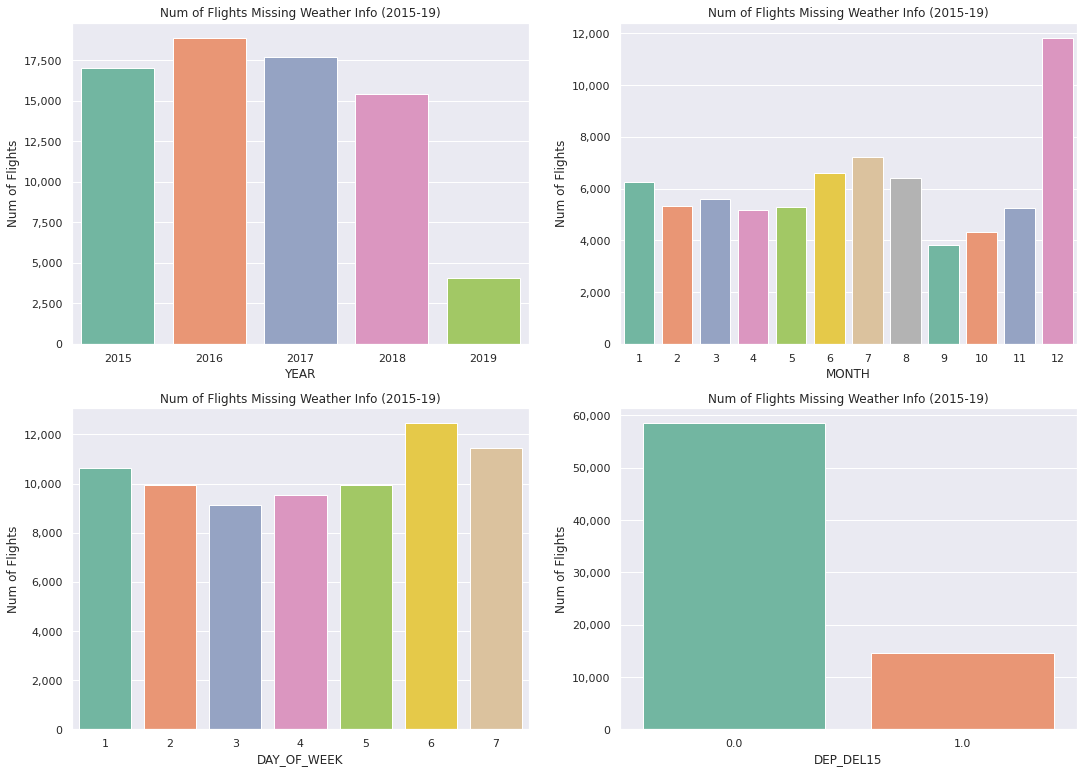

In [0]:
plot_cols = ["YEAR","MONTH", "DAY_OF_WEEK","DEP_DEL15"]
fig = plt.figure(figsize=(18,13))
for col,num in zip(plot_cols, range(1,len(plot_cols)+1)):
    ax = fig.add_subplot(2,2,num)
    pddf_plot = pddf_na_weather.groupby(col).agg({'OP_CARRIER_FL_NUM':'count'})
    plt.title("Num of Flights Missing Weather Info (2015-19)")
    sns.barplot(x=pddf_plot.index, 
                y=pddf_plot["OP_CARRIER_FL_NUM"], 
                palette=sns.color_palette("Set2"))
    ax.set_xlabel(f"{col}")
    ax.set_ylabel("Num of Flights")
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
    plt.xticks(rotation=0)

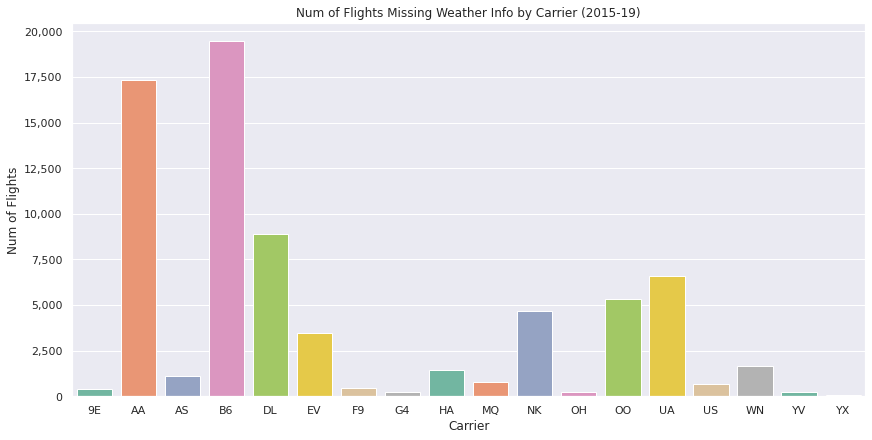

In [0]:
fig, ax = plt.subplots(figsize=(12, 6), constrained_layout=True)
pddf_plot =  pddf_na_weather.groupby("OP_UNIQUE_CARRIER").agg({'OP_CARRIER_FL_NUM':'count'})
plt.title("Num of Flights Missing Weather Info by Carrier (2015-19)")
sns.barplot(x=pddf_plot.index, y=pddf_plot["OP_CARRIER_FL_NUM"], palette=sns.color_palette("Set2"))
ax.set_xlabel("Carrier")
ax.set_ylabel("Num of Flights")
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter("{x:,.0f}")) 
plt.xticks(rotation=0)
pass